**Data Science - course work**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
from scipy.stats import mannwhitneyu

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import r2_score # r2 -> goodness of fit in linear regression

from sklearn.svm import SVR #support vector regression



ModuleNotFoundError: No module named 'matplotlib'

Task 1.2 - Exploratory Data analysis

In [ ]:
df_features = pd.read_csv('/Users/chiaraspear/anaconda_projects/datenanalyse-gruppenprojekt/MIT_fingertapping_dataset/MIT_USERS_FEATURES.csv')
#change path to where the file is stored

df_features.head(10)

1.2.1 Boxplot to visualise difference in UPDRS scores for the Healthy and Parkinson’s patients

In [ ]:
healthy_UPDRS = df_features.loc[df_features['Parkinsons'] == False, 'UPDRS']
parkinsons_UPDRS = df_features.loc[df_features['Parkinsons'] == True, 'UPDRS']

print(f"Parkinson's mean UPDRS: {parkinsons_UPDRS.mean()}")
print(f"Healthy mean UPDRS: {healthy_UPDRS.mean()}")

In [ ]:
sns.boxplot(data=df_features, x='Parkinsons', y='UPDRS')

plt.title('UPDRS Score by Group', fontsize=14, weight='bold')
plt.xlabel('Group', fontsize=12)
plt.ylabel('UPDRS', fontsize=12)
plt.xticks([0, 1], ['Healthy', "Parkinson's"])
plt.tight_layout()
plt.show()



1.2.2 Difference UPDRS score Healthy vs Parkinsons - t-test + assumption checks

Assumptions for t-test: 
- normality -> tested with Shapiro-Wilk test
- Equal variances -> tested with Levene test
- independence -> yes, because each participant only tested once

In [ ]:
# Normality: Shapiro-Wilk test

stat_healthy_normality, p_healthy_normality = shapiro(healthy_UPDRS)
stat_parkinsons_normality, p_parkinsons_normality = shapiro(parkinsons_UPDRS)

print(f"Healthy group normality p-value: {p_healthy_normality:.3f}")
print(f"Parkinson's group normality p-value: {p_parkinsons_normality:.3f}")

# Equal variances: Levene test
stat_levene, p_levene = levene(healthy_UPDRS, parkinsons_UPDRS)

print(f"Levene’s test p-value: {p_levene:.3f}")


- Results assumption checks: no normality in healthy group + no equal variances -> assumptions for t-test not met 
- this is why we will use Wilcoxon rank-sum test (also called Mann-Whitney U test) instead -> non-parametric alternative

In [ ]:
stat_wilcoxon, p_wilcoxon = mannwhitneyu(healthy_UPDRS, parkinsons_UPDRS)
print(f"Mann-Whitney U test: statistic = {stat_wilcoxon}, p-value = {p_wilcoxon}")

In [ ]:
print("Healthy UPDRS range:")
print(f"Min: {healthy_UPDRS.min():.2f}, Max: {healthy_UPDRS.max():.2f}")

print("\nParkinson's UPDRS range:")
print(f"Min: {parkinsons_UPDRS.min():.2f}, Max: {parkinsons_UPDRS.max():.2f}")


chat GPT: So there’s no overlap at all between the two groups' UPDRS scores. That’s why the Mann-Whitney U statistic is 0.0, and the p-value is basically zero.

This result is expected and makes sense:

    Every Parkinson’s patient scores higher than every Healthy participant.

    The difference is not just statistically significant — it’s absolute in this sample

1.2.3 Correlations of all feature variables

In [ ]:
features_only_df = df_features.drop(columns=['ID', 'Parkinsons'])
sns.pairplot(features_only_df, corner=True)
plt.suptitle('Pairplot of Feature Variables')
plt.show()

this is a lot -> hard to visually analyse -> additionally: correlation heatmap

In [ ]:
corr = features_only_df.corr()                                          # Computes the Pearson correlation coefficient between all pairs 
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Heatmap of Feature Variables')
plt.show()

**2.1 Linear Regression of Feautures against UPDRS score**

2.1.1- Perform a linear regression of the feature variables against UPDRS score.Don’t forget to split your data into training and testing appropriately!

In [ ]:
# lets clean the data before splitting into independent and dependent variables
# do we have any nan values?

features_only_df.isna().any(axis=0) # features_only_df = feature matrix

-> no NaN data

In [ ]:
# dependent variable y =  UPDRS (predicted)
y = features_only_df['UPDRS']

# predictors = all other feature variables 
x = features_only_df.drop(columns=['UPDRS'])

# train test split your data with a test size of 30% of your data
# helpful tip for this dataset only - set the random state argument to random_state=6 (makes it reproducable - everytime same distribution)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 6 )

#scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# train a linear regression model on the train data
model = LinearRegression()
model.fit(x_train_scaled, y_train)

# now predict for your test values
y_test_prediction = model.predict(x_test_scaled)


 2.1.2- Which features display the strongest relationship? What are their coefficients? Use an
 appropriate measure to define the goodness of fit.

In [ ]:
# R² (Goodness of Fit)
r2 = r2_score(y_test, y_test_prediction)
print(r2)

chatgpt: Negative values → model performs worse than predicting the mean

-> zusammenhang wahrscheinlich nicht linear

In [ ]:
# what are our coefficients for  the intercept? 
print(model.intercept_)


In [ ]:
# what are our coefficients for each feature? (beta for x)    
coefficients = pd.Series(model.coef_, index=x.columns)
print(coefficients.sort_values(ascending=False))

In [ ]:
# strongest features (absolute value)
strongest_features = coefficients.abs().sort_values(ascending=False)
print(strongest_features.head())

**2.2 Non-linear regression of features against UPDRS score (15 marks)**

2.2.1- Perform a non-linear regression of the feature variables against UPDRS score, using a support vector machine. Don’t forget to split your data into training and testing appropriately!

In [ ]:
# (difference to class: support vector regressor instead of classifier)

# we can reuse the train test split and the scaling from before (linear regression)

# Create SVR model - RBF kernel (Radial Basis Function) -> non-linear
svm = SVR(kernel='rbf')

# Train on scaled training data
svm.fit(x_train_scaled, y_train)

# Predict on scaled test data
y_test_pred_svm = svm.predict(x_test_scaled)

In [ ]:
# Evaluate: R² (Goodness of Fit)
r2_svm = r2_score(y_test, y_test_pred_svm)
print(r2_svm)


 2.2.2-  Compare and contrast your results with the linear regression.

-> way better than linear regression (see different R2 scores)

Task 3


   ID  Parkinsons  median_flight_time  std_flight_time  median_hold_time  \
0  11        True               142.9       184.584488              93.9   
1  60       False               529.0       837.476992             122.9   
2  67        True               476.5      1154.993782             179.2   
3  68       False               361.6       823.429272             151.0   
4  70        True               617.7      1434.028934             179.7   

   std_hold_time  std_binned_flight_time  std_binned_hold_time  hand_symmetry  \
0      44.440760                4.693407              1.739548          848.0   
1      37.994156               66.097678              4.373105          239.0   
2      77.017094               81.909059             13.111766          248.0   
3      25.416287               39.183555              2.243013          301.0   
4      42.075270              147.909365              7.374355          140.0   

   mean_flight_symmetry  mean_hold_symmetry  std_flight_

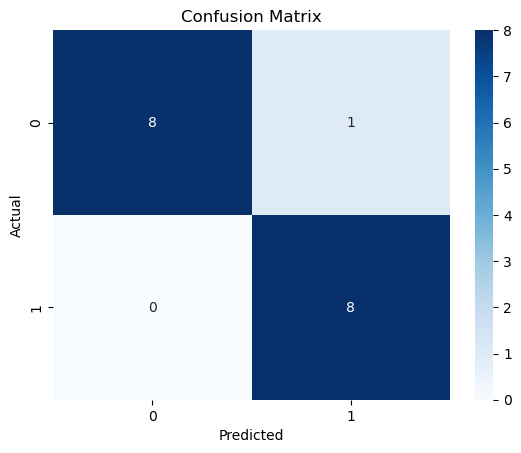

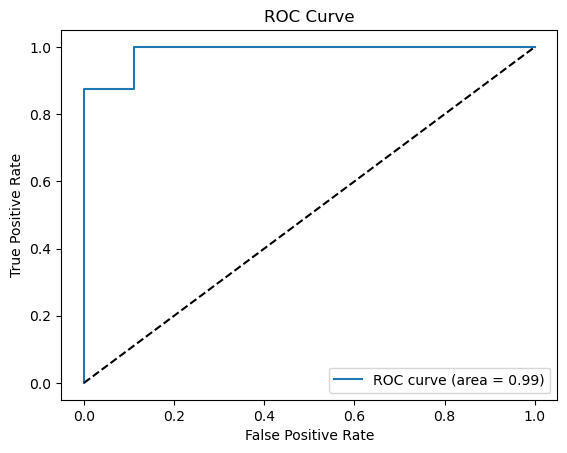

In [13]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Daten laden
data = pd.read_csv("/Users/ronny/Downloads/MIT_fingertapping_dataset/MIT_USERS_FEATURES.csv")  # Pfad anpassen

#data = data[~data.group.isin(['UPDRS'])]
data = data.drop(columns=['UPDRS'])

data = data.reset_index(drop=True)

#labels, label_names = pd.factorize(data['group'])

#data['group'] = labels

y = data["Parkinsons"]
X = data.drop(columns=["Parkinsons"])

# Daten anschauen
print(data.head())

# Features standardisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Daten splitten (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression Modell erstellen
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

# Accuracy berechnen
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Cross-Validation Accuracy
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")

# Confusion Matrix visualisieren
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Optional: ROC Curve visualisieren
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Test Accuracy (SVC): 0.82
Mean CV Accuracy (SVC): 0.74


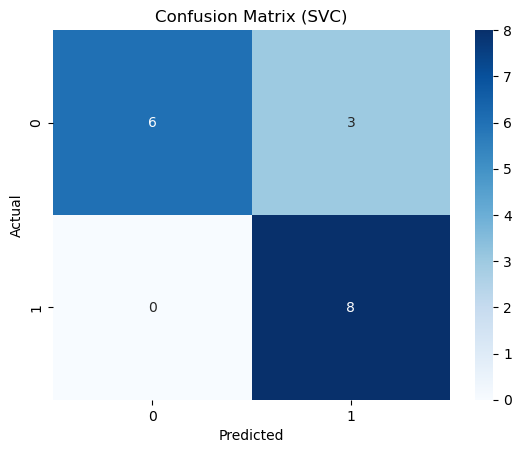

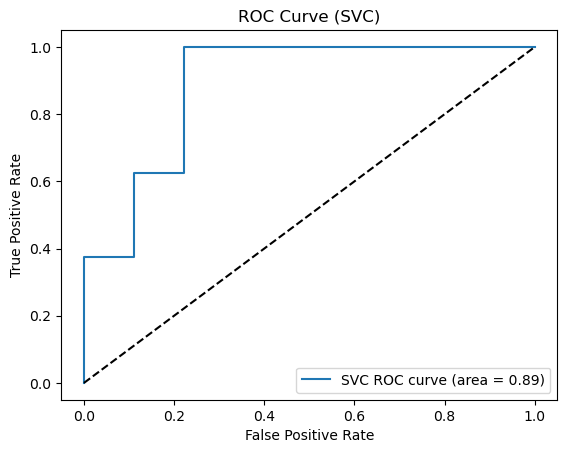

In [18]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Daten laden
data = pd.read_csv("/Users/ronny/Downloads/MIT_fingertapping_dataset/MIT_USERS_FEATURES.csv")  # Pfad anpassen

# Falls 'UPDRS' enthalten ist -> löschen
if "UPDRS" in data.columns:
    data = data.drop(columns=['UPDRS'])

data = data.reset_index(drop=True)

# Zielvariable und Features definieren
y = data["Parkinsons"]
X = data.drop(columns=["Parkinsons"])

# Features standardisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Daten splitten (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Support Vector Classifier Modell erstellen (mit Wahrscheinlichkeitsausgabe für ROC)
svc = SVC(kernel="rbf", probability=True, random_state=42)
svc.fit(X_train, y_train)

# Vorhersagen
y_pred = svc.predict(X_test)

# Accuracy berechnen
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (SVC): {accuracy:.2f}")

# Cross-Validation Accuracy
cv_scores = cross_val_score(svc, X_scaled, y, cv=5)
print(f"Mean CV Accuracy (SVC): {cv_scores.mean():.2f}")

# Confusion Matrix visualisieren
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVC)")
plt.show()

# ROC Curve visualisieren
y_prob = svc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"SVC ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVC)")
plt.legend(loc="lower right")
plt.show()


In [20]:
from sklearn.decomposition import PCA

# PCA Reduktion auf 10 Dimensionen
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Splitten
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression auf PCA-Daten
log_reg_pca = LogisticRegression(max_iter=1000)
log_reg_pca.fit(X_train_pca, y_train)
y_pred_pca = log_reg_pca.predict(X_test_pca)
print("Logistic Regression PCA Accuracy:", accuracy_score(y_test, y_pred_pca))

# Support Vector Classifier auf PCA-Daten
svc_pca = SVC(kernel="rbf", probability=True, random_state=42)
svc_pca.fit(X_train_pca, y_train)
y_pred_svc_pca = svc_pca.predict(X_test_pca)
print("SVC PCA Accuracy:", accuracy_score(y_test, y_pred_svc_pca))


Logistic Regression PCA Accuracy: 0.8823529411764706
SVC PCA Accuracy: 0.8235294117647058
